<a href="https://colab.research.google.com/github/JinJiyanAzadi/REMOTE_SENSING_DEEP_LEARNING_2024/blob/main/Copia_di_03_Forest_Fires_Prediction_ENSAMBLE_STACKING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forestfire impact prediction

In [115]:
%pip install ucimlrepo

<img src='https://upload.wikimedia.org/wikipedia/commons/d/d8/Deerfire_high_res_edit.jpg' width='1200px'/>

---

# Objective

Forest fires help in the natural cycle of woods' growth and replenishment. They Clear dead trees, leaves, and competing vegetation from the forest floor, so new plants can grow. Remove weak or disease-ridden trees, leaving more space and nutrients for stronger trees.


But when fires burn too hot and uncontrollable or when they’re in the “wildland-urban interface” (the places where woodlands and homes or other developed areas meet), they can be damaging and life threatning.


In this kernel, our aim is to predict the burned area (`area`) of forest fires, in the northeast region of Portugal. Based on the the spatial, temporal, and weather variables where the fire is spotted.

This prediction can be used for calculating the forces sent to the incident and deciding the urgency of the situation.

In [116]:
target = 'area'

---

# Define the metrics

**RMSE**

RMSE is the most popular evaluation metric used in regression problems. It follows an assumption that error are unbiased and follow a normal distribution.

Further read: [Analyticsvidhya](https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/)

---

# Dependencies

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

plt.style.use('ggplot')

from scipy.stats import zscore
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error


import xgboost as xgb


---

# Load and describe data

In [118]:
# fetch dataset
forest_fires = fetch_ucirepo(id=162)

In [119]:
forest_fires.metadata

{'uci_id': 162,
 'name': 'Forest Fires',
 'repository_url': 'https://archive.ics.uci.edu/dataset/162/forest+fires',
 'data_url': 'https://archive.ics.uci.edu/static/public/162/data.csv',
 'abstract': 'This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data (see details at: http://www.dsi.uminho.pt/~pcortez/forestfires).',
 'area': 'Climate and Environment',
 'tasks': ['Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 517,
 'num_features': 12,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['area'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2007,
 'last_updated': 'Thu Jan 11 2024',
 'dataset_doi': '10.24432/C5D88D',
 'creators': ['Paulo Cortez', 'Anbal Morais'],
 'intro_paper': {'title': 'A data mining approach to predict forest fires using meteorological data',
  'a

In [120]:
print(forest_fires.metadata.additional_info.variable_info)

For more information, read [Cortez and Morais, 2007].
   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: 'jan' to 'dec' 
   4. day - day of the week: 'mon' to 'sun'
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).


In [121]:
# Concatenate features and targets into one DataFrame
df = pd.concat([forest_fires.data.features, forest_fires.data.targets], axis=1)

In [122]:
df.dtypes

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [123]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


---

# Missing value treatment

In [124]:
df.isna().sum().sum()

0

---

# Exploratory Data Analysis


In [125]:
%pwd

'/content'

   Now we will try out the following analysis on our dataset
   - Univariate
   - Bivariate
   - Multivariate

In [126]:
plt.rcParams["figure.figsize"] = 9,5

---

## Univariate analysis



### Let's begin with the target variable, `Area`

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


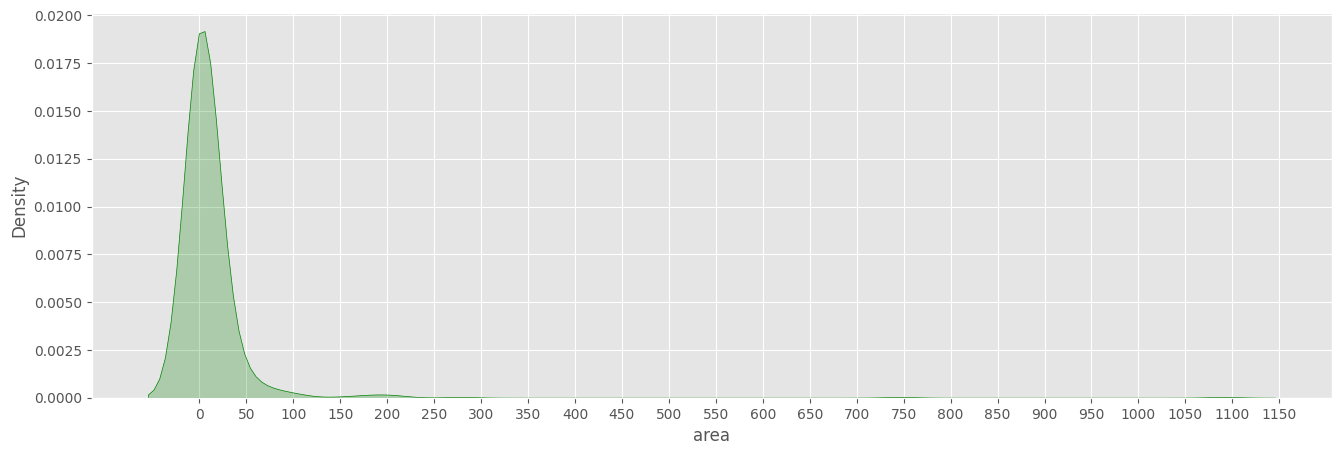

In [127]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df[target].skew()))
print("Kurtosis: {}".format(df[target].kurtosis()))
ax = sns.kdeplot(df[target], fill=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

<Axes: ylabel='area'>

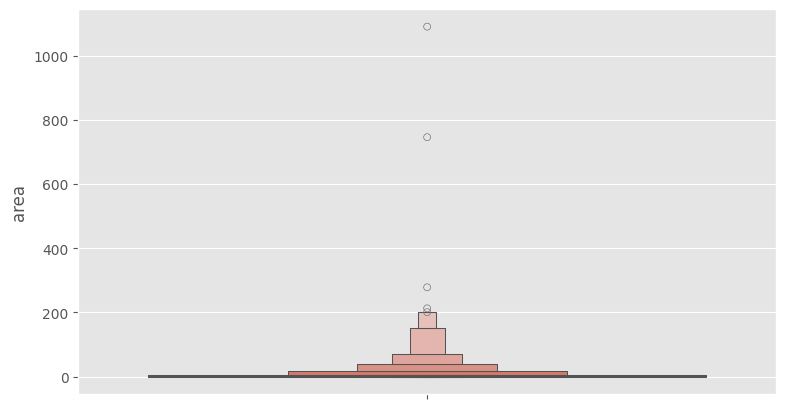

In [128]:
sns.boxenplot(data=df[target])

**Skew** is the degree of distortion from a normal distribution. skewed, meaning there are a minority of very large values.

If skewness is positive, the data are positively skewed or skewed right, meaning that the right tail of the distribution is longer than the left. If skewness is negative, the data are negatively skewed or skewed left, meaning that the left tail is longer.

 - If skewness is less than −1 or greater than +1, the distribution is highly skewed.
 - If skewness is between −1 and −½ or between +½ and +1, the distribution is moderately skewed.
 - If skewness is between −½ and +½, the distribution is approximately symmetric.

**Kurtosis** is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution . High kurtosis in a data set is an indicator that data has heavy tails or outliers.

A normal distribution has kurtosis exactly 3 (excess kurtosis exactly 0). Any distribution with kurtosis ≈3 (excess ≈0) is called mesokurtic.
A distribution with kurtosis <3 (excess kurtosis <0 ) is called platykurtic. Compared to a normal distribution, its tails are shorter and thinner, and often its central peak is lower and broader.
A distribution with kurtosis >3 (excess kurtosis >0) is called leptokurtic. Compared to a normal distribution, its tails are longer and fatter, and often its central peak is higher and sharper.

 - Feature columns:- 'ISI', & 'rain' have skewness values more than +1 so they are right skewed.

 - Feature columns:- 'FFMC', & 'temp' have skewness, values less than -1 so, they are left skewed.

 - Feature columns:- 'FFMC', 'ISI', & 'rain' have higher kurtosis value so they have outliers.


**Few observations:**

- The data is highly skewed with a value of +12.84 and huge kurtosis value of 194.

- It even tells you that majority of the forest fires do not cover a large area, most of the damaged area is under 50 hectares of land.

- We can apply tranformation to fix the skewnesss and kurtosis, however we will have to inverse transform before submitting the output.

- Outlier Check: There are 4 outlier instances in our area columns but the questions is should we drop it or not? (Will get back to this in the outlier treatment step)

In [129]:
# Outlier points
y_outliers = df[abs(zscore(df[target])) >= 3 ]
y_outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


### Independent columns

In [130]:
dfa = df.drop(columns=target)
cat_columns = dfa.select_dtypes(include='object').columns.tolist()
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

cat_columns,num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

### Categorical columns

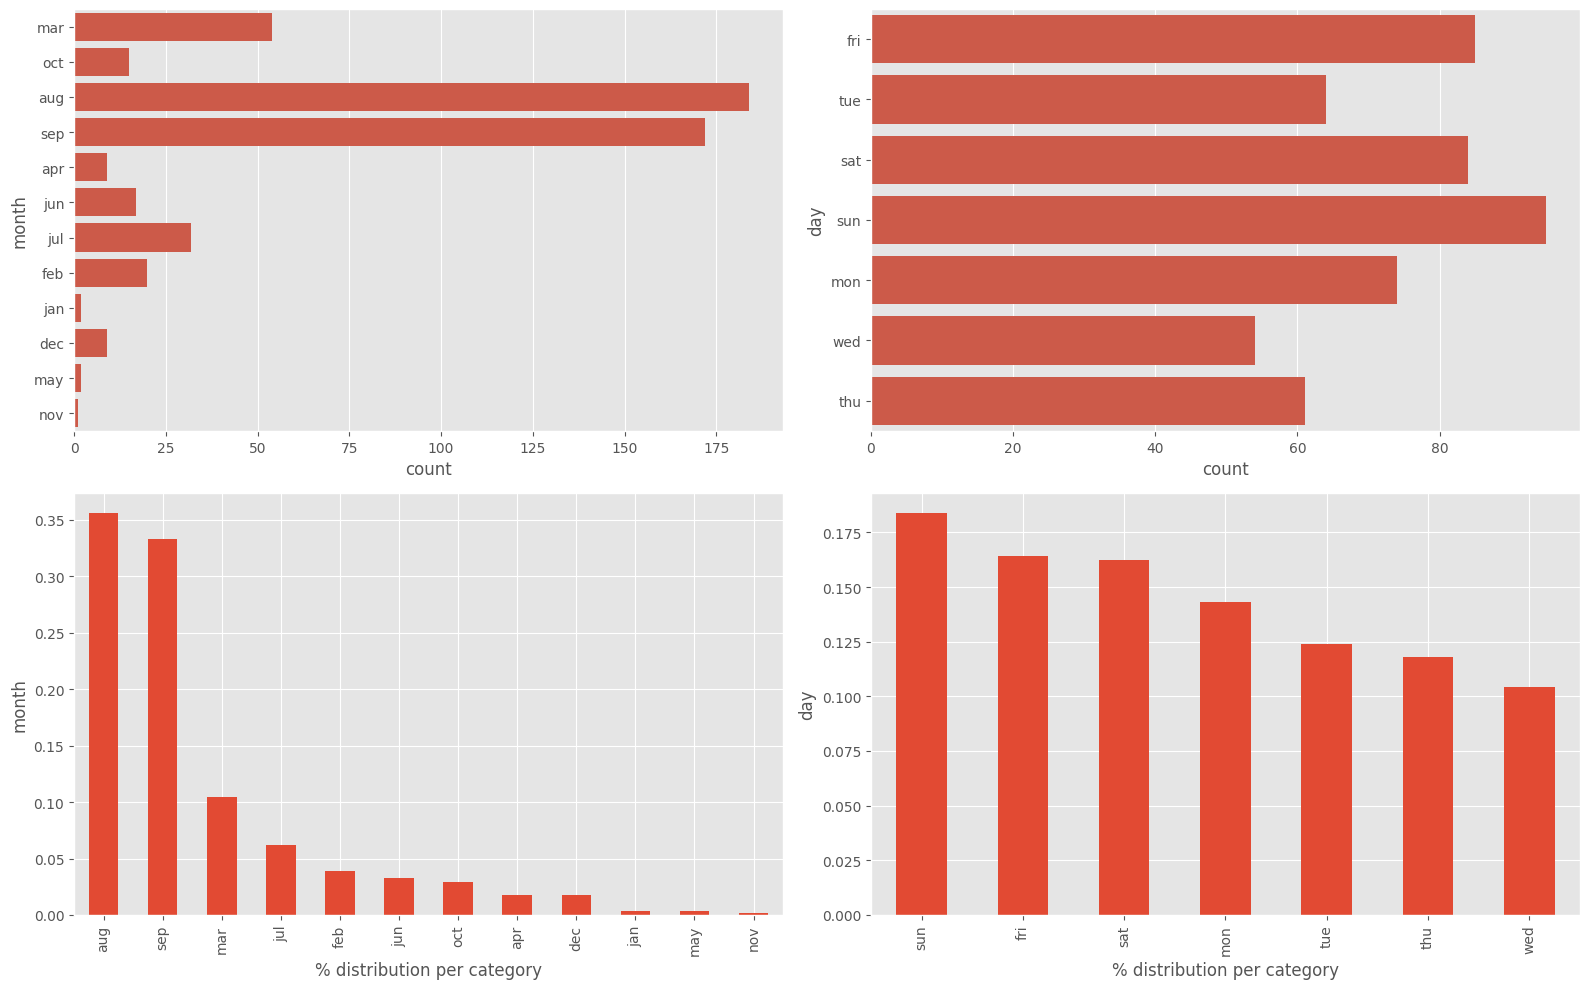

In [131]:
# analyzing categorical columns
plt.figure(figsize=(16,10))
for i,col in enumerate(cat_columns,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

1. It is interesting to see that abnormally high number of the forest fires occur in the month of `August`
and `September`.

2. In the case of day, the days `Friday` to `Monday` have higher proportion of cases. (However, no strong indicators)

### Numerical Columns

In [132]:
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


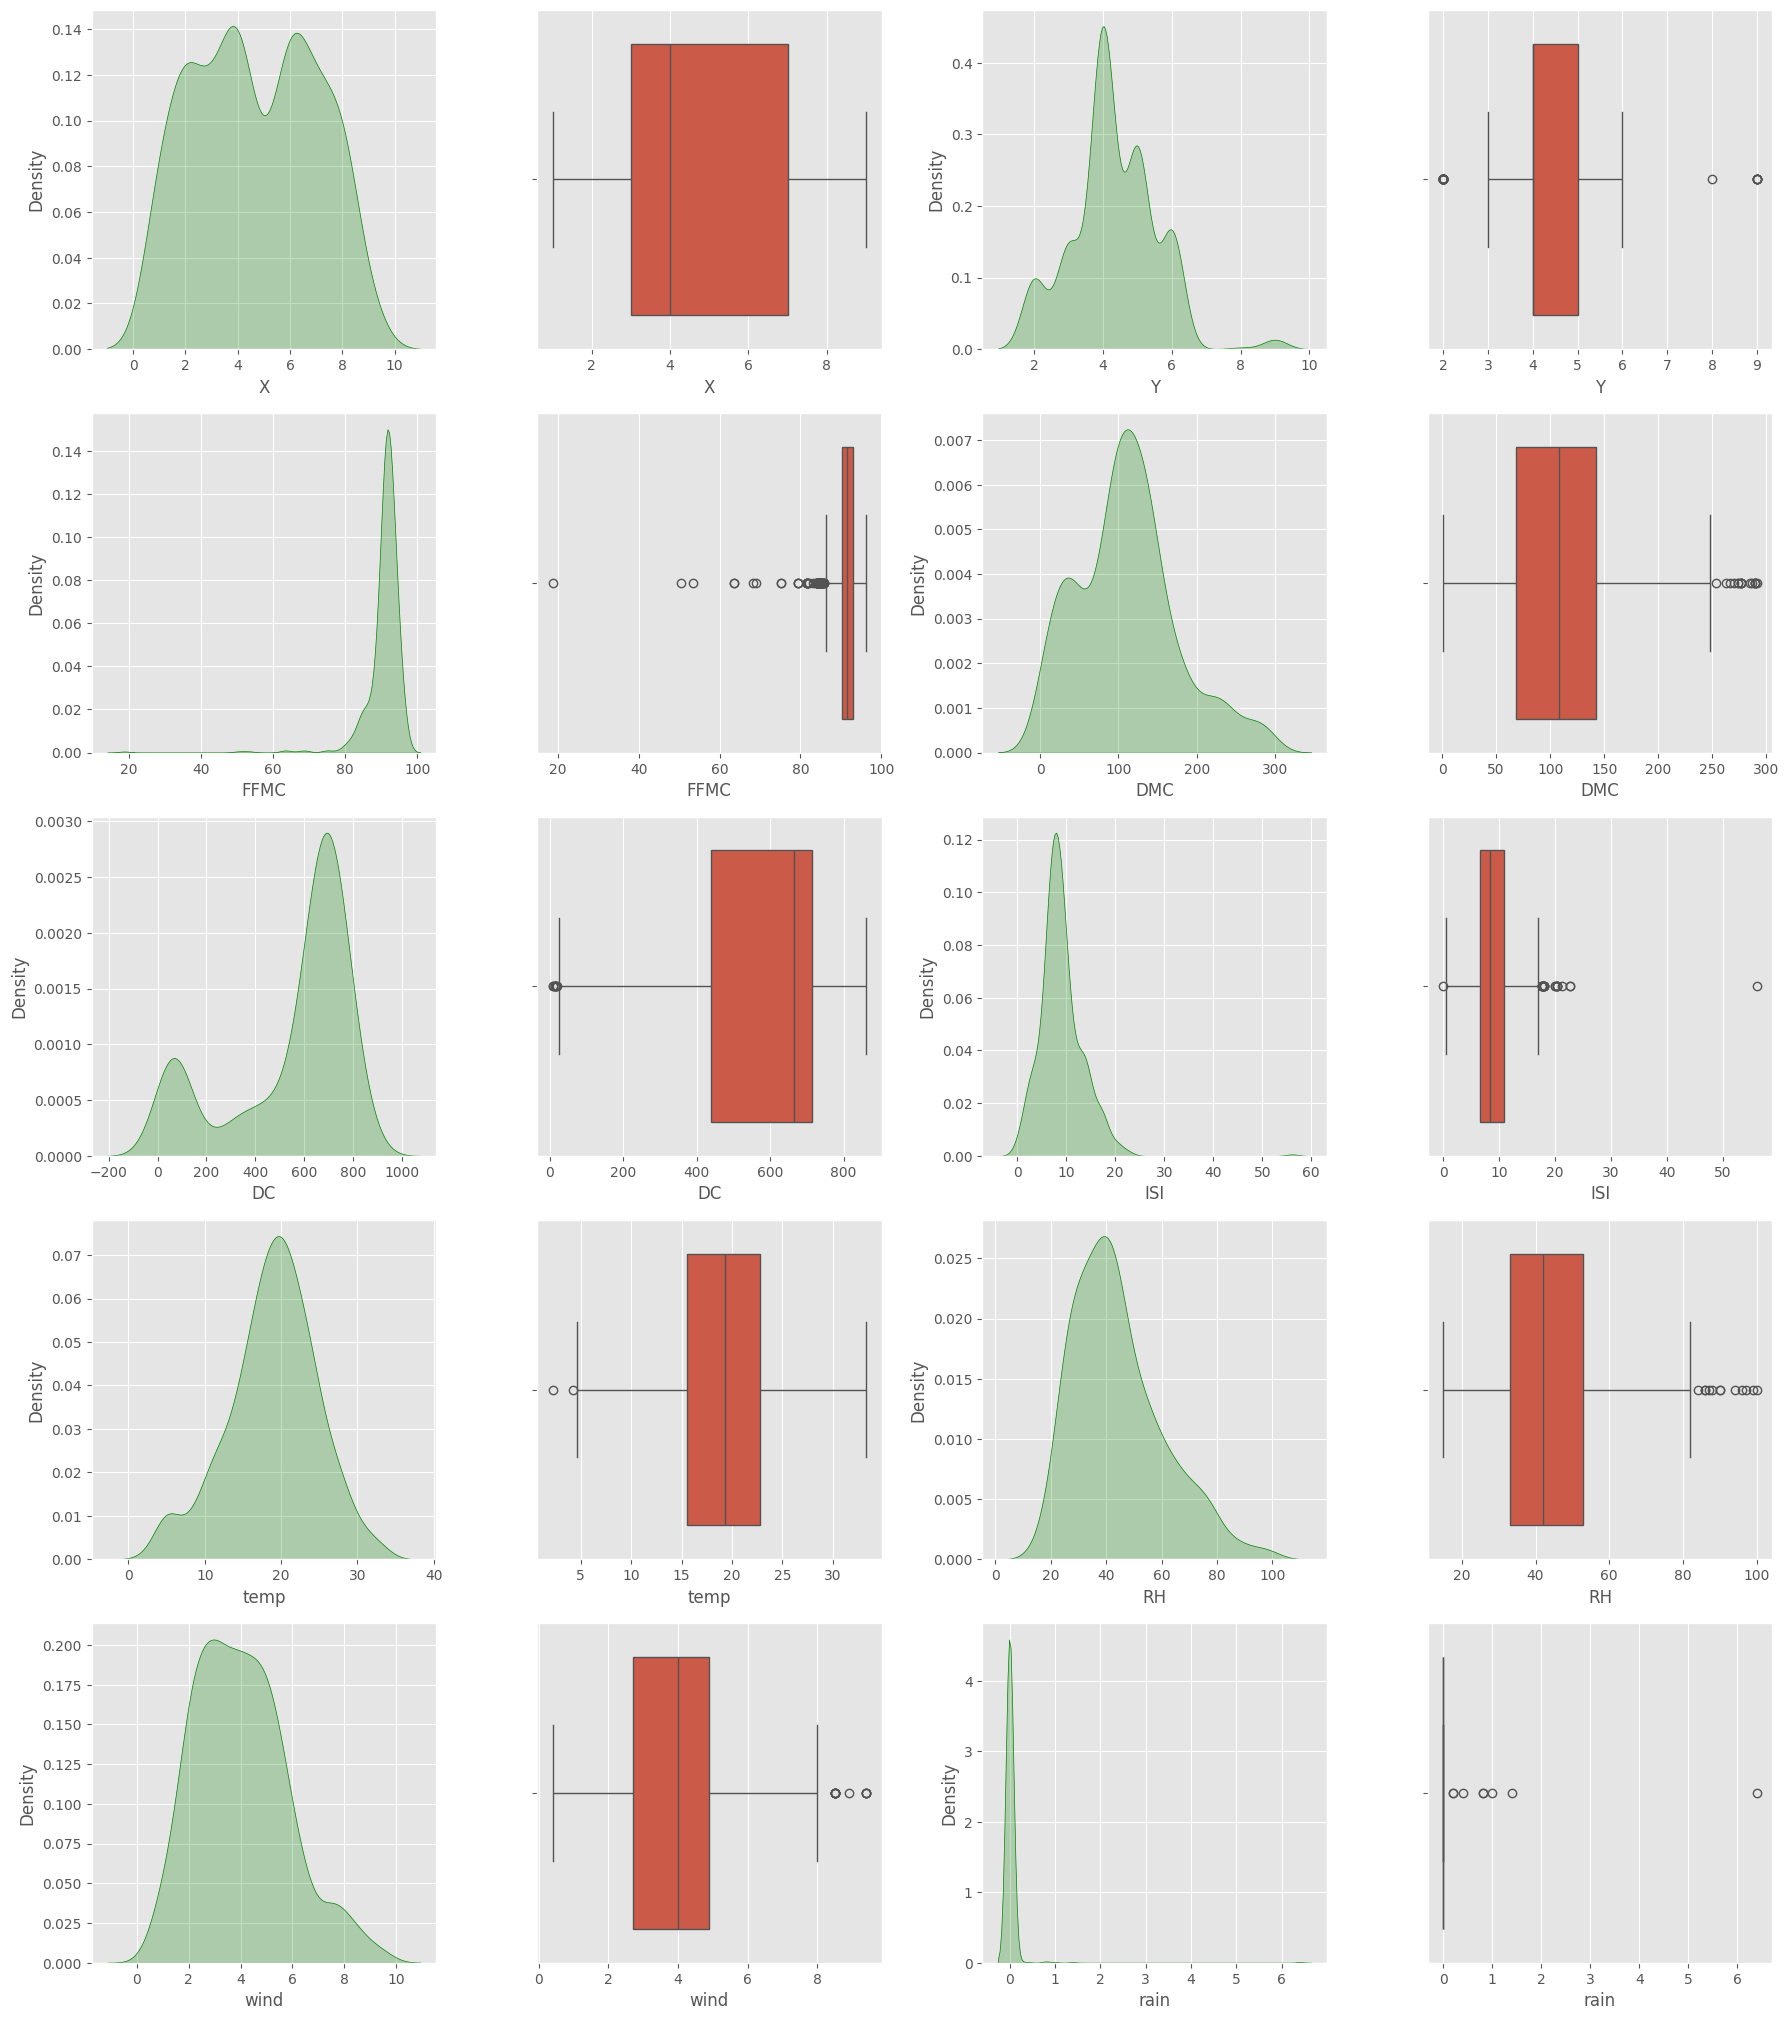

In [133]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,4,(i-1)*2+1)
    sns.kdeplot(df[col],color='g',fill=True)
    plt.subplot(10,4,(i-1)*2+2)
    sns.boxplot(x=df[col])

plt.tight_layout()
plt.show()


Outliers, Skewness and kurtosis (high positive or negative) was observed in the following columns:
1. FFMC
2. ISI
3. rain

---

## Bivariate analysis with our target variable

In [134]:
print(df['area'].describe(),'\n')
print(y_outliers)

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64 

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain     area
237  1  2   sep  tue  91.0  129.5  692.6   7.0  18.8  40   2.2   0.0   212.88
238  6  5   sep  sat  92.5  121.1  674.4   8.6  25.1  27   4.0   0.0  1090.84
415  8  6   aug  thu  94.8  222.4  698.6  13.9  27.5  27   4.9   0.0   746.28
479  7  4   jul  mon  89.2  103.9  431.6   6.4  22.6  57   4.9   0.0   278.53


In [135]:
# a categorical variable based on forest fire area damage
# No damage, low, moderate, high, very high
def area_cat(area):
    if area == 0.0:
        return "0 - no damage"
    elif area <= 1:
        return "1 - low"
    elif area <= 25:
        return "2 - moderate"
    elif area <= 100:
        return "3 - high"
    else:
        return "4 - very high"

df['damage_category'] = df['area'].apply(area_cat)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,damage_category
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0 - no damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0 - no damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0 - no damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0 - no damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0 - no damage


### Categorical columns

In [136]:
cat_columns

['month', 'day']

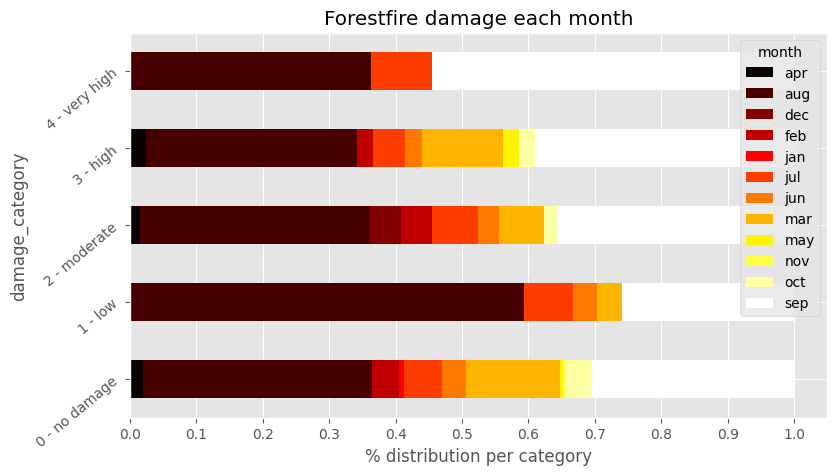

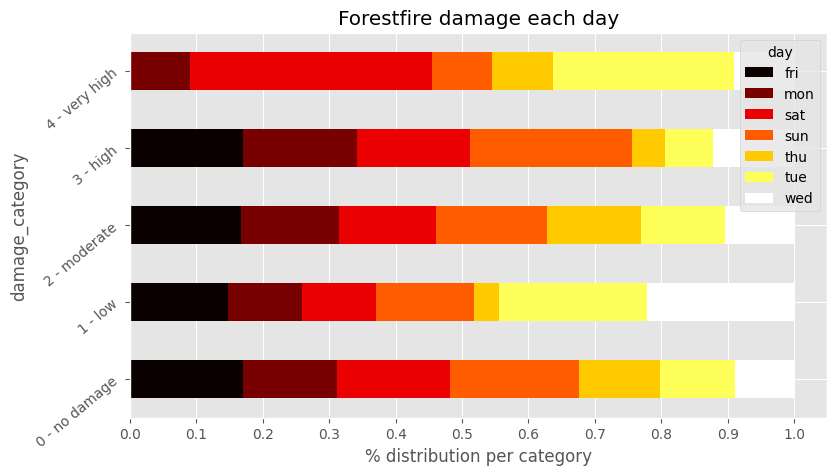

In [137]:
for col in cat_columns:
    cross = pd.crosstab(index=df['damage_category'],columns=df[col],normalize='index')
    cross.plot.barh(stacked=True,rot=40,cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0,1.1,0.1))
    plt.title("Forestfire damage each {}".format(col))
plt.show()

- Previously we had observed that `August` and `September` had the most number of forest fires. And from the above plot of `month`, we can understand few things
    - Most of the fires in August were low (< 1 hectare).
    - The very high damages(>100 hectares) happened in only 3 months - august,july and september.

- Regarding fire damage per day, nothing much can be observed. Except that, there were no ` very high` damaging fires on Friday and on Saturdays it has been reported most.

### Numerical columns

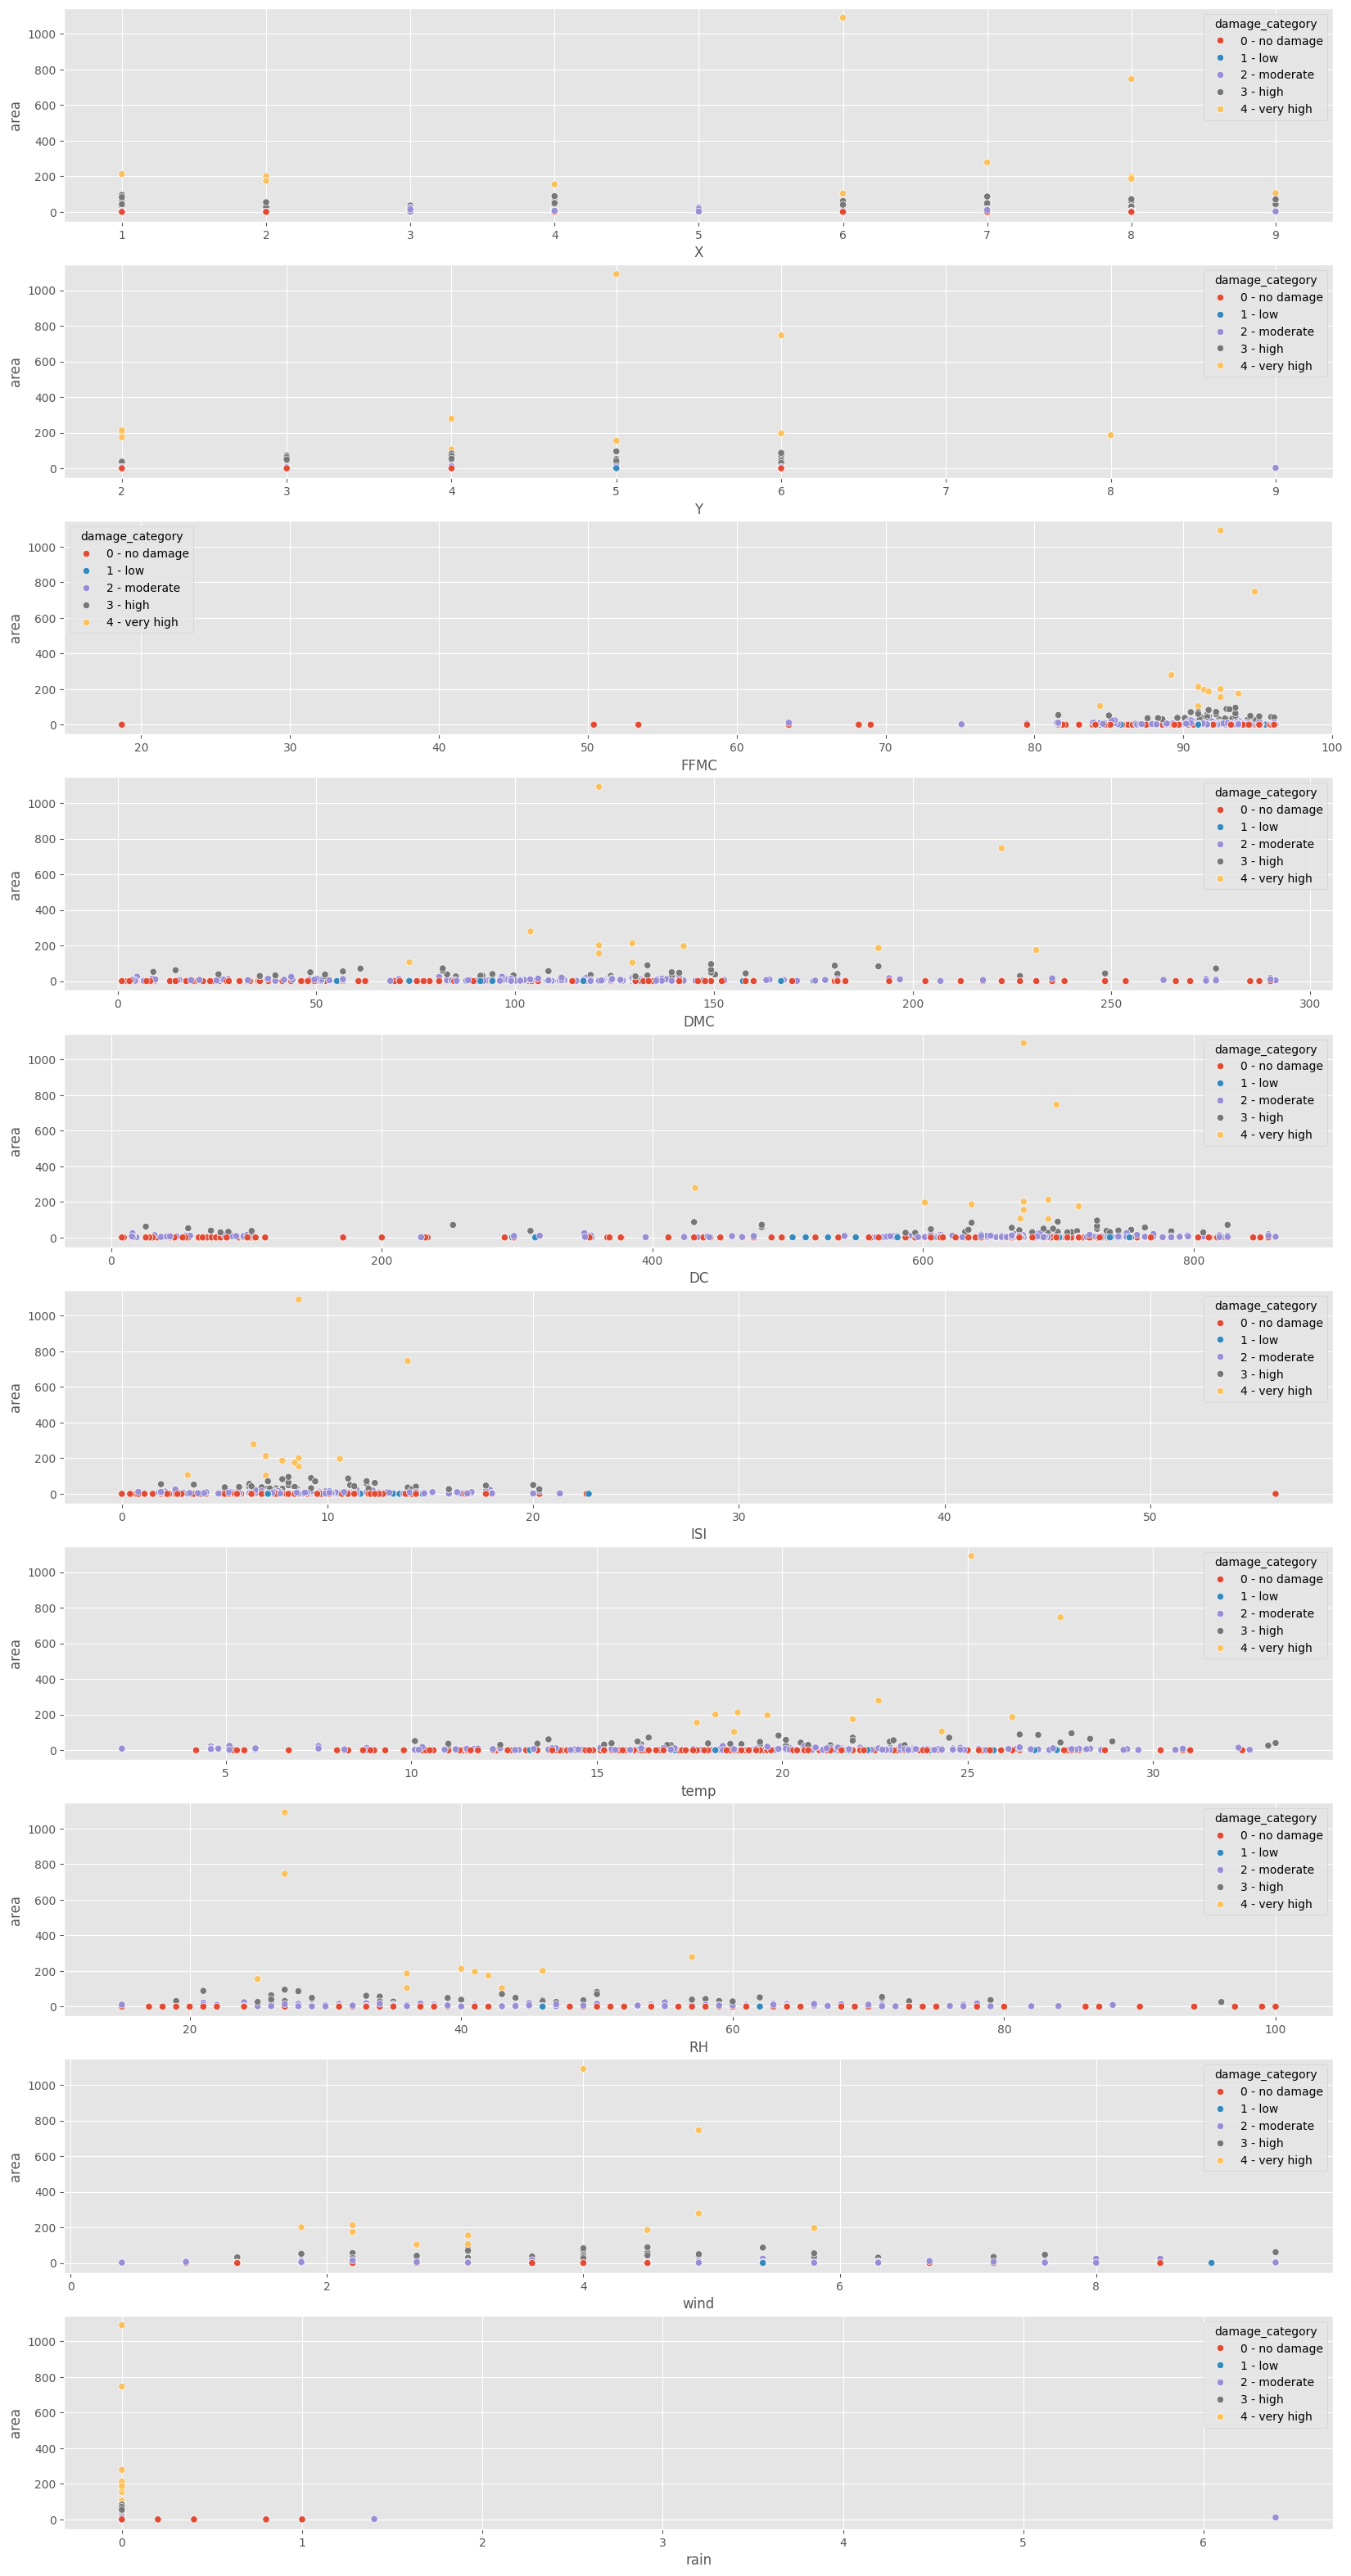

In [138]:
plt.figure(figsize=(20,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(10,1,i)
    sns.scatterplot(data=df,x=col,y=target,hue='damage_category')
plt.show()

Text(0.5, 1.0, 'Burnt area in different regions of the park')

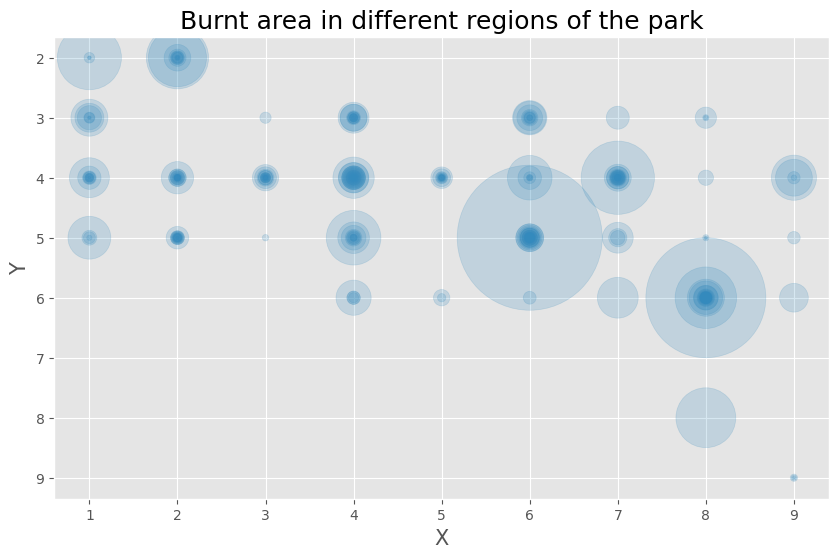

In [139]:
# Analysis of Burnt area based on spatial cordinates(X,Y)
df.plot(kind='scatter', x='X', y='Y', alpha=0.2, s=10*df['area'],figsize=(10,6))
plt.xlabel('X',fontsize=15)
plt.ylabel('Y',fontsize=15)
plt.gca().invert_yaxis()
plt.title('Burnt area in different regions of the park', fontsize=18)

---

## Multivariate analysis

In [140]:
selected_features = df.drop(columns=['damage_category','day','month']).columns
selected_features

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area'],
      dtype='object')

In [141]:
#sns.pairplot(df,hue='damage_category',vars=selected_features)
#plt.show()

---

# Outlier treatment

We had observed outliers in the following columns:
1. area
2. FFMC
2. ISI
3. rain

In [142]:
out_columns = ['area','FFMC','ISI','rain']

However, the above outliers are not error values so we cannot remove it.

In order to minimize the effect of outliers in our model we will transform the above features.

**Ref:** https://humansofdata.atlan.com/2018/03/when-delete-outliers-dataset/

---

# Preparing the data for modelling
Thing which we can cover here
- Encoding the categorical columns

In [143]:
df = pd.get_dummies(df,columns=['day','month'],drop_first=True)

- Data transformations like `log,root,inverse,exponential`,etc

In [144]:
df[out_columns].describe()

,area,FFMC,ISI,rain
count,517.000000,517.000000,517.000000,517.000000
mean,12.847292,90.644681,9.021663,0.021663
std,63.655818,5.520111,4.559477,0.295959
min,0.000000,18.700000,0.000000,0.000000
25%,0.000000,90.200000,6.500000,0.000000
50%,0.520000,91.600000,8.400000,0.000000
75%,6.570000,92.900000,10.800000,0.000000
max,1090.840000,96.200000,56.100000,6.400000


In [145]:
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,0.036246,0.417296,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,-1.172331,1.420553,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [146]:
# FFMC and rain are still having high skew and kurtosis values,
# so for FFMC we can remove the outliers in them using z-score method
mask = df.loc[:,['FFMC']].apply(zscore).abs() < 3

# Since most of the values in rain are 0.0, we can convert it as a categorical column
df['rain'] = df['rain'].apply(lambda x: int(x > 0.0))

df = df[mask.values]
df.shape

(510, 29)

In [147]:
out_columns.remove('rain')
df[out_columns] = np.log1p(df[out_columns])

<ipython-input-147-303316c91209>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_columns] = np.log1p(df[out_columns])


In [148]:
df[out_columns].skew()

area    1.208492
FFMC   -1.803993
ISI    -0.434372
dtype: float64

In [173]:
# we will use this dataframe for building our ML model
df_ml = df.drop(columns=['damage_category']).copy()

---

## Applying xgboost

In [177]:
X, y = df_ml.iloc[:,:-1],df_ml.iloc[:,-1]

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

In [179]:
xg_reg = xgb.XGBRegressor(base_score=0.3, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.24, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=1, n_estimators=102,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       eval_metric=["rmse"], subsample=1)

In [180]:
from scipy.spatial.distance import cdist

def create_spatial_features(coordinates, target_values):
    num_points = len(coordinates)
    new_feature_step_0 = np.zeros(num_points)
    new_feature_step_1 = np.zeros(num_points)
    new_feature_step_2 = np.zeros(num_points)

    distances = cdist(coordinates, coordinates, 'euclidean')

    for i in range(num_points):
        neighbors_step_0 = np.where(distances[i] == 0)[0]
        new_feature_step_0[i] = np.mean(target_values[neighbors_step_0])

        neighbors_step_2 = np.where(distances[i] == 2)[0]
        new_feature_step_2[i] = np.mean(target_values[neighbors_step_2])
        neighbors_step_1 = np.where(distances[i] == 1)[0]
        new_feature_step_1[i] = np.mean(target_values[neighbors_step_1])

        neighbors_step_2 = np.where(distances[i] == 2)[0]
        new_feature_step_2[i] = np.mean(target_values[neighbors_step_2])

    return new_feature_step_0, new_feature_step_1, new_feature_step_2

In [181]:
X_train['avg_0'], X_train['avg_1'], X_train['avg_2'] = create_spatial_features(X_train[['X', 'Y']].values, df['area'].values)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [155]:
X_train.isnull().sum()

X            0
Y            0
FFMC         0
DMC          0
DC           0
ISI          0
temp         0
RH           0
wind         0
rain         0
area         0
day_mon      0
day_sat      0
day_sun      0
day_thu      0
day_tue      0
day_wed      0
month_aug    0
month_dec    0
month_feb    0
month_jan    0
month_jul    0
month_jun    0
month_mar    0
month_may    0
month_nov    0
month_oct    0
avg_0        0
avg_1        5
avg_2        4
dtype: int64

In [182]:
X_train.fillna(0, inplace=True)

In [183]:
avg_for_point = X_train[['X', 'Y', 'area','avg_0','avg_1','avg_2']].groupby(['X', 'Y']).first()

In [158]:
avg_for_point.reset_index(inplace=True)

In [184]:
avg_for_point.drop(columns=['area'], inplace=True)

In [185]:
 avg_for_point

avg_0     avg_1     avg_2
X Y                              
1 2  0.898202  0.370395  0.876448
  3  0.367331  0.876644  1.407303
  4  0.876448  0.822856  1.036881
  5  1.407303  0.860996  0.968673
2 2  0.371928  0.876840  0.912565
  3  0.641854  0.604847  1.091759
  4  0.912565  0.971927  0.885275
  5  0.847751  1.153775  0.908779
3 4  1.095552  1.159348  0.949175
  5  1.670240  0.989809  1.055477
  6  1.160506  1.319991  1.045519
4 3  1.319499  1.197748  0.852216
  4  1.197748  1.068896  1.001309
  5  0.922828  1.205225  1.273695
  6  0.969741  0.914037  1.095094
5 4  0.964096  1.166667  0.992511
  5  0.000000  1.134873  1.390311
  6  0.611894  0.674271  1.079745
6 3  0.776799  1.312609  1.360225
  4  1.231213  1.067627  1.123518
  5  1.513520  1.052573  0.876084
  6  0.308086  1.454652  0.887963
7 3  1.597496  0.858524  1.237623
  4  0.941270  1.299517  0.963959
  5  1.237623  1.204514  2.331236
  6  2.687847  0.872227  0.884523
8 3  0.439695  1.685840  0.826743
  4  1.862529  0.870574  0.876552
  5  1.076463  1.060216  1.384661
  6  0.807590  1.183447  0.557357
  8  0.000000  0.000000  0.807590
9 4  0.388601  3.441239  0.910906
  5  4.230594  0.627885  1.237623
  6  0.000000  0.987748  0.963413
  9  1.951304  0.000000  0.000000

In [161]:
X_test = pd.merge(X_test, avg_for_point, on=['X','Y'], how='left')

In [186]:
X_test.isnull().sum()

X            0
Y            0
FFMC         0
DMC          0
DC           0
ISI          0
temp         0
RH           0
wind         0
rain         0
area         0
day_mon      0
day_sat      0
day_sun      0
day_thu      0
day_tue      0
day_wed      0
month_aug    0
month_dec    0
month_feb    0
month_jan    0
month_jul    0
month_jun    0
month_mar    0
month_may    0
month_nov    0
month_oct    0
dtype: int64

In [163]:
X_test.fillna(0, inplace=True)

In [187]:
X_train.drop(columns=['X','Y'], inplace=True)
X_test.drop(columns=['X','Y'], inplace=True)

In [165]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg.fit(X_train, y_train, eval_set=eval_set, verbose=False)
preds = xg_reg.predict(X_test)

#### verbose set to False so that we can hide results of model fit progress

In [166]:
def calc_ISE(X_train, y_train, model):
    '''returns the in-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_train)
    rmse = mean_squared_error(y_train, predictions, squared=False)
    return model.score(X_train, y_train), rmse

def calc_OSE(X_test, y_test, model):
    '''returns the out-of-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return model.score(X_test, y_test), rmse

**Calculate In-Sample and Out-of-Sample R^2 and Error**

In [188]:
is_r2, ise = calc_ISE(X_train, y_train, xg_reg )
os_r2, ose = calc_OSE(X_test, y_test, xg_reg)

# show dataset sizes
data_list = (('R^2_in', is_r2), ('R^2_out', os_r2),
             ('ISE', ise), ('OSE', ose))
for item in data_list:
    print('{:10}: {}'.format(item[0], item[1]))

NotFittedError: need to call fit or load_model beforehand

**Clearly test error(OSE) is near to the training error(ISE). i.e our model is ok.
**

In [168]:
print('train/test: ', ose/ise)

train/test:  0.9898207


In [189]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))


RMSE: 0.314832


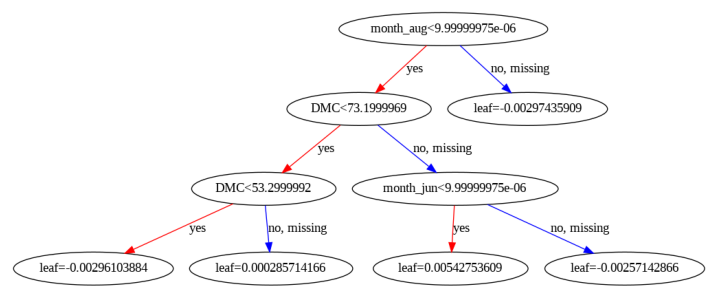

In [170]:
xgb.plot_tree(xg_reg,num_trees=0)

plt.rcParams['figure.figsize'] = [15, 15]
plt.show()


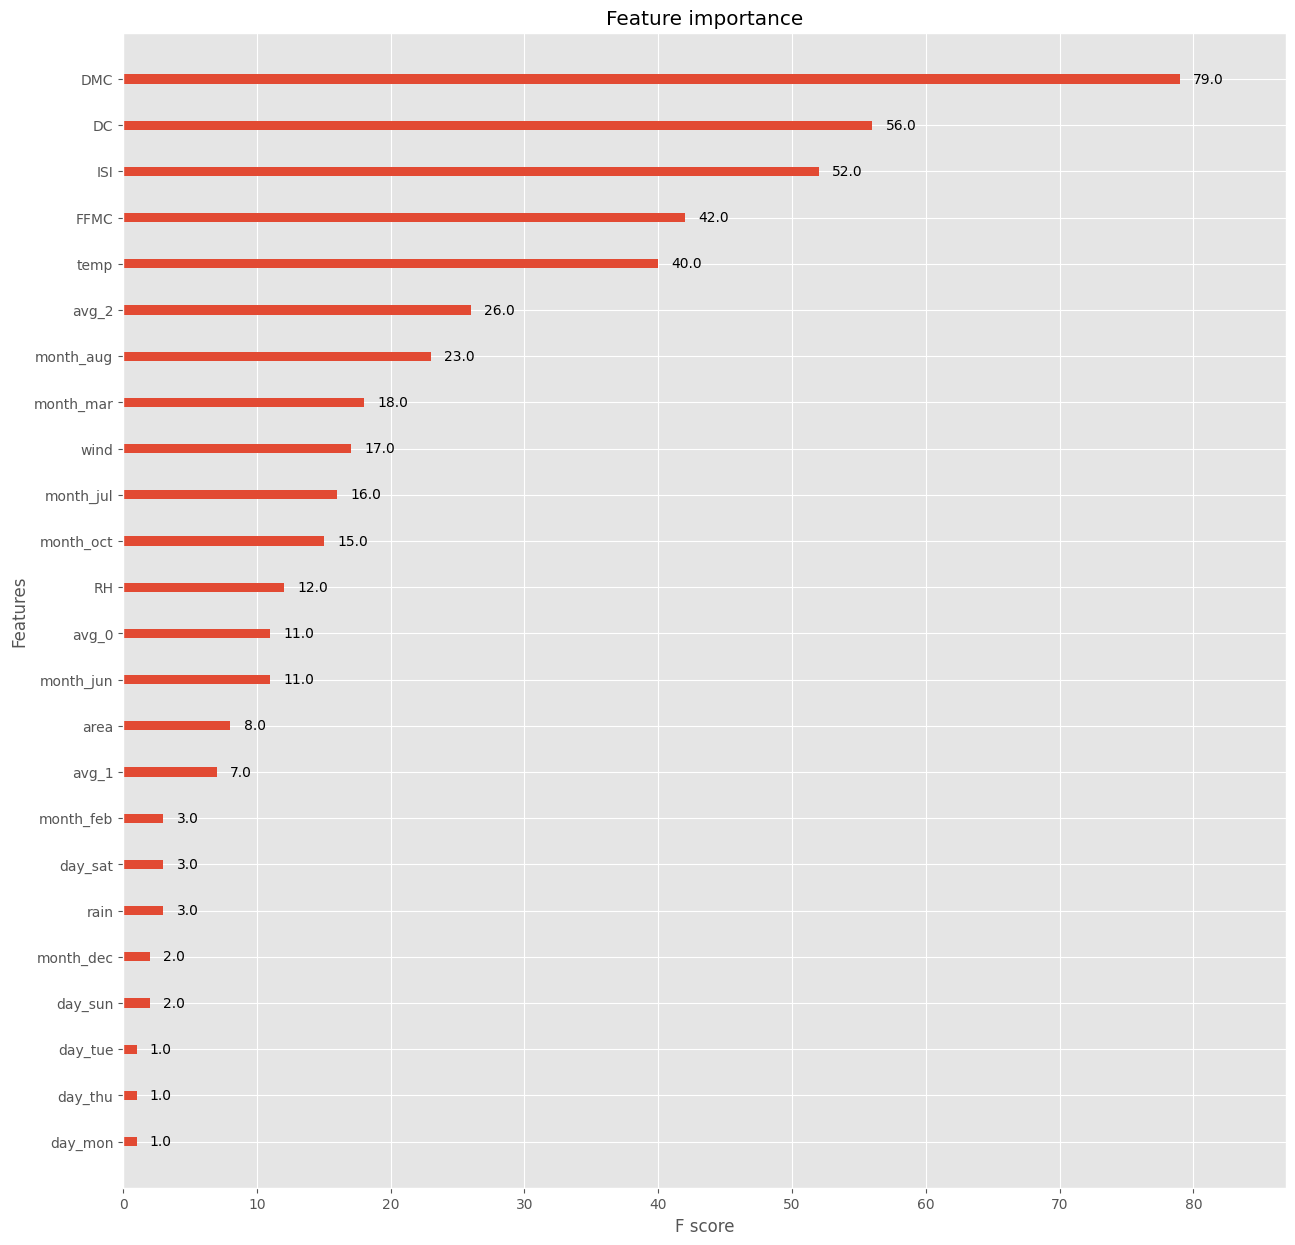

In [171]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [7, 7]
plt.show()


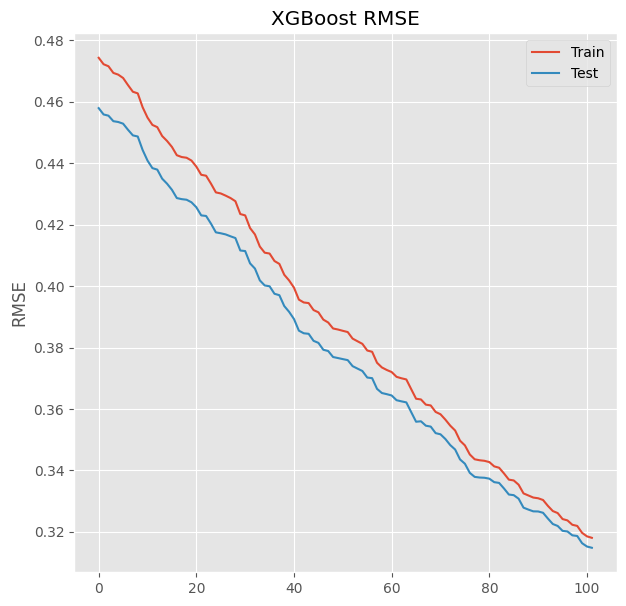

In [172]:
# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot RMSE
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

# credits

In [10]:
# MY VARIATION
# https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# to create a synthetic regression problem with 1,000 examples and 20 input features. Using the ENSEMBLE LEARNING method --> STACKING with linear regression

# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

 [Forest fire prediction with XGBoost](https://www.kaggle.com/code/lucca9211/forest-fire-prediction-with-xgboost)

 [Forest fire impact prediction stats and ML](https://www.kaggle.com/code/psvishnu/forestfire-impact-prediction-stats-and-ml)

 [Forest fire](https://www.kaggle.com/code/sammy9025/forestfire)




In [12]:
 # test regression dataset
from sklearn.datasets import make_regression
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


In [13]:
# get the dataset
def get_dataset():
 X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
 return X, y

In [14]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 return models

In [16]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores

>knn -101.019 (7.161)
>cart -147.512 (10.900)
>svm -162.419 (12.565)


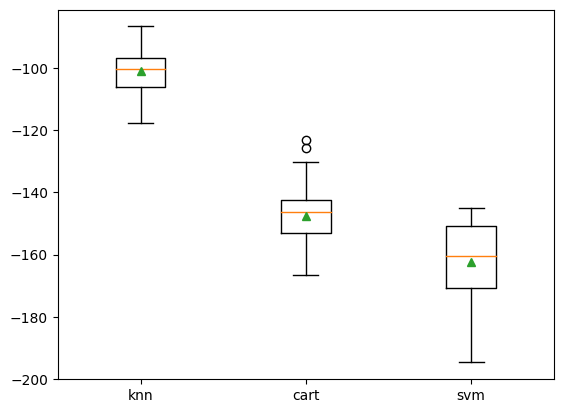

In [17]:
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

We can see that in this case, KNN performs the best with a mean negative MAE of about -100.

**Mean Absolute Error**

In the context of machine learning, absolute error refers to the magnitude of difference between the prediction of an observation and the true value of that observation.

Next, we can try to combine these three models into a single ensemble model using stacking.


We can use a **linear regression model** to learn how to best combine the predictions from each of the separate three models.


The **get_stacking() function** below defines the StackingRegressor model by first defining a list of tuples for the three base models, then defining the linear regression meta-model to combine the predictions from the base models using 5-fold cross-validation.

In [18]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model

We can include the stacking ensemble in the list of models to evaluate, along with the standalone models.


This is not always the case, and if it is not the case, then the base model should be used in favor of the ensemble model.



In [19]:
# get a list of models to evaluate
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['stacking'] = get_stacking()
 return models

>knn -101.019 (7.161)
>cart -147.380 (10.551)
>svm -162.419 (12.565)
>stacking -56.581 (5.212)


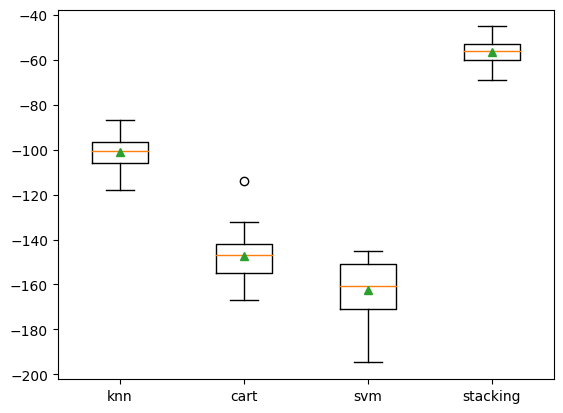

In [20]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
 return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

A box plot is created showing the distribution of model error scores. Here, we can see that the mean and median scores for the stacking model sit much higher than any individual model.


If we choose a stacking ensemble as our final model, **we can fit and use it to make predictions on new data** just like any other model.


First, the stacking ensemble is fit on all available data, then the *predict()* function can be called to make predictions on new data.


In [21]:
# make a prediction with a stacking ensemble
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
# define dataset
X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
# define the base models
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
level0.append(('svm', SVR()))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
data = [[0.59332206,-0.56637507,1.34808718,-0.57054047,-0.72480487,1.05648449,0.77744852,0.07361796,0.88398267,2.02843157,1.01902732,0.11227799,0.94218853,0.26741783,0.91458143,-0.72759572,1.08842814,-0.61450942,-0.69387293,1.69169009]]
yhat = model.predict(data)
print('Predicted Value: %.3f' % (yhat))

Predicted Value: 556.891


<ipython-input-21-db228aa52863>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted Value: %.3f' % (yhat))


Running the example fits the stacking ensemble model on the entire dataset and is then **used to make a prediction on a new row of data**, as we might when using the model in an application.

The example for the **stacking code** is taken from the following:

 https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/